# DHUM 1300 Final Project: 
## An Exploration of *Billboard* Hot 100 Hit Lyrics During the 2010s
## By Alice Liao

The *Billboard* Hot 100 is a chart that measures and ranks the best-performing songs in the United States. As popular songs and popular culture as a whole are often reflective of society's attitudes and perspectives. This project examines lyrics of *Billboard* Hot 100 number ones from the years 2010 through 2019 to answer the following question: "How did the lyrics of popular songs change during the 2010s?"

As this project will only conduct a text analysis, there will be little to no analysis related to music theory, production, vocals, and marketing. However, the lyrics and poetic structure of the songs may reflect these other aspects of popular music.

# Basic Setting

In [20]:
import nltk # Import NLTK
nltk.download('punkt') 
from nltk import word_tokenize
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
import pandas as pd

In [22]:
import re # Import Regular Expressions package to divide a text into meaningful segments
import matplotlib as mpl
import matplotlib.pyplot as plt # Use matplotlib for graphs
import requests # For work with web pages
import numpy as np # Import Numpy for faster work with arrays
import itertools # Import itertools for efficient looping
import sys
import json
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter

In [23]:
import string # get string for its built-in punctuation list


# Collecting Billboard Songs as a Dataframe

In [31]:
# Import LyricsGenius client
%pip install git+https://github.com/johnwmillr/LyricsGenius.git
import lyricsgenius as genius

  Cloning https://github.com/johnwmillr/LyricsGenius.git to /tmp/pip-req-build-uhebsw3s
  Running command git clone -q https://github.com/johnwmillr/LyricsGenius.git /tmp/pip-req-build-uhebsw3s
  Created wheel for lyricsgenius: filename=lyricsgenius-3.0.1-cp37-none-any.whl size=44672 sha256=f318a9dda1306521e3d89535b12e89eeebeb4772fd5136af6bbecc0997a1fbca
  Stored in directory: /tmp/pip-ephem-wheel-cache-zoilldfn/wheels/4c/c2/c2/711389881353cc8ef2f0055a712da5db9637132bc10151212e
Successfully built lyricsgenius


In [32]:
# Import BeautifulSoup
from bs4 import BeautifulSoup

In [33]:
# Collect Billboard song lyrics
# Modified from https://github.com/sharpie-007/dataAndMusic
def collect_songs_from_billboard(start_year,end_year):
    '''This function takes in a start year and and end year, then iterates 
    through each year to pull song data from Billboard. It uses BeautifulSoup to
    clean the data. Finally, it stores the cleaned data in a dataframe and 
    returns it.
    
    Parameters:
    
    start_year (int): the year to start at.
    end_year (int): the year to end at.
    Returns: dataframe.
    '''
    
    years = np.arange(start_year, end_year + 1).astype(int)
    dataset = pd.DataFrame()
    url_list = []
    all_years = pd.DataFrame()

    #URL Constructor
    for i in range (0, len(years)):
        url_list.append("https://www.billboard.com/charts/year-end/" + str(years[i]) + "/hot-100-songs")      
    for i in range(0, len(url_list)):
            sys.stdout.write("\r" + "Collecting Songs from " +str(years[i]) + " via https://www.billboard.com")
            sys.stdout.flush()
            url = "https://www.billboard.com/charts/year-end/" + str(years[i]) + "/hot-100-songs"
            page = requests.get(url)
            soup = BeautifulSoup(page.content, "html.parser")
            all_ranks = soup.find_all("div", class_="ye-chart-item__rank")
            all_titles = soup.find_all('div', class_="ye-chart-item__title")
            all_artists = soup.find_all("div", class_="ye-chart-item__artist")
            for j in range (0, len(all_ranks)):
                row = {
                    "Rank": all_ranks[j].get_text(strip=True),
                    "Song Title": all_titles[j].get_text(strip=True),
                    "Artist": all_artists[j].get_text(strip=True),
                    "Year": years[i]
                }
                dataset = dataset.append(row, ignore_index=True)
    dataset['Year'] = dataset['Year'].astype(int)
    return dataset

In [34]:
billboard = collect_songs_from_billboard(2010, 2019)

In [35]:
# Check that data has been collected
display(billboard.head(5))
display(billboard.tail(5))
display(billboard.shape)

,Artist,Rank,Song Title,Year
0,Ke$ha,1,TiK ToK,2010
1,Lady Antebellum,2,Need You Now,2010
2,Train,3,"Hey, Soul Sister",2010
3,Katy Perry Featuring Snoop Dogg,4,California Gurls,2010
4,Usher Featuring will.i.am,5,OMG,2010


,Artist,Rank,Song Title,Year
993,Chase Rice,96,Eyes On You,2019
994,Dan + Shay,97,All To Myself,2019
995,Ariana Grande & Social House,98,Boyfriend,2019
996,P!nk,99,Walk Me Home,2019
997,Juice WRLD,100,Robbery,2019


(998, 4)

# Collecting Song Lyrics from Genius.com

In [36]:
api = genius.Genius('KsktWpNDQFu-eYVhGBqRdK_yNwi-ydg5m0xoJKumc-My07qnZb859CiN4kfA4-7K', 
                    skip_non_songs=True, 
                    remove_section_headers=True)

In [37]:
billboard_data = pd.DataFrame()
start_time = datetime.now()
print("Started at {}".format(start_time)) # Time stamps help track long process
for i in range(0, len(billboard)): # iterates through dataset from Billboard
    rolling_pct = int((i/len(billboard))*100)
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(billboard)) +". Year " + str(billboard.iloc[i]['Year']) + "." + " Currently collecting " + 
          billboard.iloc[i]['Song Title'] + " by " + billboard.iloc[i]['Artist'] + " "*50, end="\r")
    song_title = billboard.iloc[i]['Song Title']
    song_title = re.sub(" and ", " & ", song_title)
    artist_name = billboard.iloc[i]['Artist']
    artist_name = re.sub(" and ", " & ", artist_name)

    try:
        song = api.search_song(song_title, artist=artist_name) # Search for song
        #print(song)
        # Collect lyrics
        song_lyrics = re.sub("\n", " ", song.lyrics) #Remove newline breaks, we won't need them.
    except:
        song_lyrics = "null"
        
    row = {
        "Year": billboard.iloc[i]['Year'],
        "Rank": billboard.iloc[i]['Rank'],
        "Song Title": billboard.iloc[i]['Song Title'],
        "Artist": billboard.iloc[i]['Artist'],
        "Lyrics": song_lyrics
    }
    billboard_data = billboard_data.append(row, ignore_index=True) # adds lyrics to dataframe
end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))

Started at 2021-05-09 21:14:46.835296
Searching for "TiK ToK" by Ke$ha...
Done.
Searching for "Need You Now" by Lady Antebellum...
Done.
Searching for "Hey, Soul Sister" by Train...
Done.
Searching for "California Gurls" by Katy Perry Featuring Snoop Dogg...
Done.
Searching for "OMG" by Usher Featuring will.i.am...
Done.
Searching for "Airplanes" by B.o.B Featuring Hayley Williams...
Done.
Searching for "Love The Way You Lie" by Eminem Featuring Rihanna...
Done.
Searching for "Bad Romance" by Lady Gaga...
Done.
Searching for "Dynamite" by Taio Cruz...
Done.
Searching for "Break Your Heart" by Taio Cruz Featuring Ludacris...
Done.
Searching for "Nothin' On You" by B.o.B Featuring Bruno Mars...
Done.
Searching for "I Like It" by Enrique Iglesias Featuring Pitbull...
Done.
Searching for "BedRock" by Young Money Featuring Lloyd...
Done.
Searching for "In My Head" by Jason Derulo...
Done.
Searching for "Rude Boy" by Rihanna...
Done.
Searching for "Telephone" by Lady Gaga Featuring Beyonce..

In [39]:
# Check first five rows
billboard_data.head(5)

,Artist,Lyrics,Rank,Song Title,Year
0,Ke$ha,Wake up in the morning feelin' like P. Diddy (...,1,TiK ToK,2010.0
1,Lady Antebellum,"""Hey, sorry I missed your call, just leave a m...",2,Need You Now,2010.0
2,Train,Heyy He-e-e-e-ey He-e-e-e-ey Your lipstick st...,3,"Hey, Soul Sister",2010.0
3,Katy Perry Featuring Snoop Dogg,"Greetings, loved ones Let's take a journey I ...",4,California Gurls,2010.0
4,Usher Featuring will.i.am,"Oh my gosh Baby let me I did it again, so I'm ...",5,OMG,2010.0


In [40]:
# Save data to CSV and JSON format for convenience
billboard_data.to_csv("billboard_data.csv")
billboard_data.to_json("billboard_data.json", orient='records')

In [41]:
# New dataset for convenience
loaded_billboard = pd.read_csv("billboard_data.csv",index_col=0)
display(loaded_billboard.head())
display(loaded_billboard.tail())

,Artist,Lyrics,Rank,Song Title,Year
0,Ke$ha,Wake up in the morning feelin' like P. Diddy (...,1,TiK ToK,2010.0
1,Lady Antebellum,"""Hey, sorry I missed your call, just leave a m...",2,Need You Now,2010.0
2,Train,Heyy He-e-e-e-ey He-e-e-e-ey Your lipstick st...,3,"Hey, Soul Sister",2010.0
3,Katy Perry Featuring Snoop Dogg,"Greetings, loved ones Let's take a journey I ...",4,California Gurls,2010.0
4,Usher Featuring will.i.am,"Oh my gosh Baby let me I did it again, so I'm ...",5,OMG,2010.0


,Artist,Lyrics,Rank,Song Title,Year
993,Chase Rice,We've been to both Carolinas Seen a big Montan...,96,Eyes On You,2019.0
994,Dan + Shay,I'm jealous of the blue jeans that you're wear...,97,All To Myself,2019.0
995,Ariana Grande & Social House,I'm a motherfuckin' train wreck I don't wanna ...,98,Boyfriend,2019.0
996,P!nk,There's somethin' in the way you roll your eye...,99,Walk Me Home,2019.0
997,Juice WRLD,"Man, what? (Haha) This shit funny, one sec Oof...",100,Robbery,2019.0


# Cleaning Data and Text

In [43]:
# Drop songs without lyrics
billboard_lyrics = loaded_billboard.dropna(subset=['Lyrics'])

In [44]:
billboard_lyrics.head()

,Artist,Lyrics,Rank,Song Title,Year
0,Ke$ha,Wake up in the morning feelin' like P. Diddy (...,1,TiK ToK,2010.0
1,Lady Antebellum,"""Hey, sorry I missed your call, just leave a m...",2,Need You Now,2010.0
2,Train,Heyy He-e-e-e-ey He-e-e-e-ey Your lipstick st...,3,"Hey, Soul Sister",2010.0
3,Katy Perry Featuring Snoop Dogg,"Greetings, loved ones Let's take a journey I ...",4,California Gurls,2010.0
4,Usher Featuring will.i.am,"Oh my gosh Baby let me I did it again, so I'm ...",5,OMG,2010.0


# Extracting Text Corpus (Lyrics)

In [49]:
import spacy # well-known NLP library

In [50]:
def add_spacy_data(dataset, feature_column):
    '''
    Grabs the verb, adverb, noun, and stop word Parts of Speech (POS) 
    tokens and pushes them into a new dataset. returns an 
    enriched dataset.
    
    Parameters:
    
    dataset (dataframe): the dataframe to parse
    feature_column (string): the column to parse in the dataset.
    
    Returns: 
    dataframe
    '''
    
    corpus = []
    nlp = spacy.load('en_core_web_sm')
    ##
    for i in range (0, len(dataset)):
        print("Extracting words from record {} of {}".format(i+1, len(dataset)), end = "\r")
        song = dataset.iloc[i][feature_column]
        doc = nlp(song)
        spacy_dataframe = pd.DataFrame()
        for token in doc:
            if token.lemma_ == "-PRON-":
                lemma = token.text
            else:
                lemma = token.lemma_
            row = {
                "Word": token.text,
                "Lemma": lemma,
                "PoS": token.pos_,
                "Stop Word": token.is_stop
            }
            spacy_dataframe = spacy_dataframe.append(row, ignore_index = True)
            # spacy_dataframe.append(row, ignore_index = True)

        corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
        corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   
        corpus.append(corpus_clean)
    print("Got here")

    # dataset['Corpus'] = corpus
    # dataset.loc['Corpus'] = corpus
    return corpus

In [51]:
def prep_corpus(raw_string):
    '''Single use of add_spacy_data to enable pipelining 
    data into predictions
    
    Parameters:
    raw_string (string): String to be parsed
    
    Returns:
    parsed string
    '''

    corpus = []
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(raw_string)
    spacy_dataframe = pd.DataFrame()
    for token in doc:
        if token.lemma_ == "-PRON-":
                lemma = token.text
        else:
            lemma = token.lemma_
        row = {
            "Word": token.text,
            "Lemma": lemma,
            "PoS": token.pos_,
            "Stop Word": token.is_stop
        }
        spacy_dataframe = spacy_dataframe.append(row, ignore_index = True)
    corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
    corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   

    return corpus_clean

In [52]:
prepared_songs = add_spacy_data(billboard_lyrics, 'Lyrics')

Got here


In [53]:
from pandas import DataFrame
billboard_df = DataFrame (prepared_songs, columns=['Lyrics'])
billboard_df.head()

,Lyrics
0,wake morning feelin like P Diddy hey girl grab...
1,hey sorry miss leave message beep hey yeah th...
2,Heyy e e e ey e e e ey lipstick stain lobe lef...
3,greeting love one let journey know place grass...
4,oh gosh Baby let gon let beat rock oh Baby let...


In [54]:
billboard_df = billboard_df.join(billboard_lyrics['Song Title'])
billboard_df = billboard_df.join(billboard_lyrics['Year'].astype(int))

In [55]:
billboard_df.head()

,Lyrics,Song Title,Year
0,wake morning feelin like P Diddy hey girl grab...,TiK ToK,2010.0
1,hey sorry miss leave message beep hey yeah th...,Need You Now,2010.0
2,Heyy e e e ey e e e ey lipstick stain lobe lef...,"Hey, Soul Sister",2010.0
3,greeting love one let journey know place grass...,California Gurls,2010.0
4,oh gosh Baby let gon let beat rock oh Baby let...,OMG,2010.0


In [56]:
word_counts = []
unique_word_counts = []
for i in range (0, len(billboard_df)):
    word_counts.append(len(billboard_df.loc[i]['Lyrics'].split()))
    unique_word_counts.append(len(set(billboard_df.loc[i]['Lyrics'].split())))
billboard_df['Word Counts'] = word_counts
billboard_df['Unique Word Counts'] = unique_word_counts

In [57]:
billboard_df.head(5)

,Lyrics,Song Title,Year,Word Counts,Unique Word Counts
0,wake morning feelin like P Diddy hey girl grab...,TiK ToK,2010.0,255,99
1,hey sorry miss leave message beep hey yeah th...,Need You Now,2010.0,77,48
2,Heyy e e e ey e e e ey lipstick stain lobe lef...,"Hey, Soul Sister",2010.0,168,70
3,greeting love one let journey know place grass...,California Gurls,2010.0,316,125
4,oh gosh Baby let gon let beat rock oh Baby let...,OMG,2010.0,498,60


In [58]:
# Save dataset as a CSV file for convenience
billboard_df.to_csv('billboard_df.csv')

# Preparing for Data Modeling

In [60]:
def wordcloud(text, max_words):
    '''
    Wrapper around Wordcloud that increases quality, picks a specific font,
    and puts it on a white background
    '''
    
    wordcloud = WordCloud(width = 4000,
                          height = 3000,
                          background_color="white",
                          max_words = max_words                          
                         ).generate(text)
    plt.figure(figsize=(40,25))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return;

In [63]:
# Clean text again
# Get stopwords list with extension
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.extend(string.punctuation)
custom_stop_list = ['yeah', 'doo', 'ai', 'la', 'na', 'hey', 'baby', 'te', 'woo', 'like', 'ooh', 'oh', 'Baby', 'e', 'ey', 'Heyy']
stopword_list.extend(custom_stop_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [64]:
billboard_df['Lyrics'] = billboard_df['Lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))

In [65]:
billboard_df.head()

,Lyrics,Song Title,Year,Word Counts,Unique Word Counts
0,wake morning feelin P Diddy girl grab glass do...,TiK ToK,2010,255,99
1,sorry miss leave message beep think tonight kn...,Need You Now,2010,77,48
2,lipstick stain lobe left brain know forget go ...,"Hey, Soul Sister",2010,168,70
3,greeting love one let journey know place grass...,California Gurls,2010,316,125
4,gosh let gon let beat rock let love way love b...,OMG,2010,498,60


In [66]:
# Prepare for sentiment analysis visualizations
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Visualizations

In [67]:
# Cast the years to integers
import math
temp = [int(year) if not math.isnan(year) else 2010 for year in billboard_df['Year']]

billboard_df['Year'] = temp
billboard_df.head()

,Lyrics,Song Title,Year,Word Counts,Unique Word Counts
0,wake morning feelin P Diddy girl grab glass do...,TiK ToK,2010,255,99
1,sorry miss leave message beep think tonight kn...,Need You Now,2010,77,48
2,lipstick stain lobe left brain know forget go ...,"Hey, Soul Sister",2010,168,70
3,greeting love one let journey know place grass...,California Gurls,2010,316,125
4,gosh let gon let beat rock let love way love b...,OMG,2010,498,60


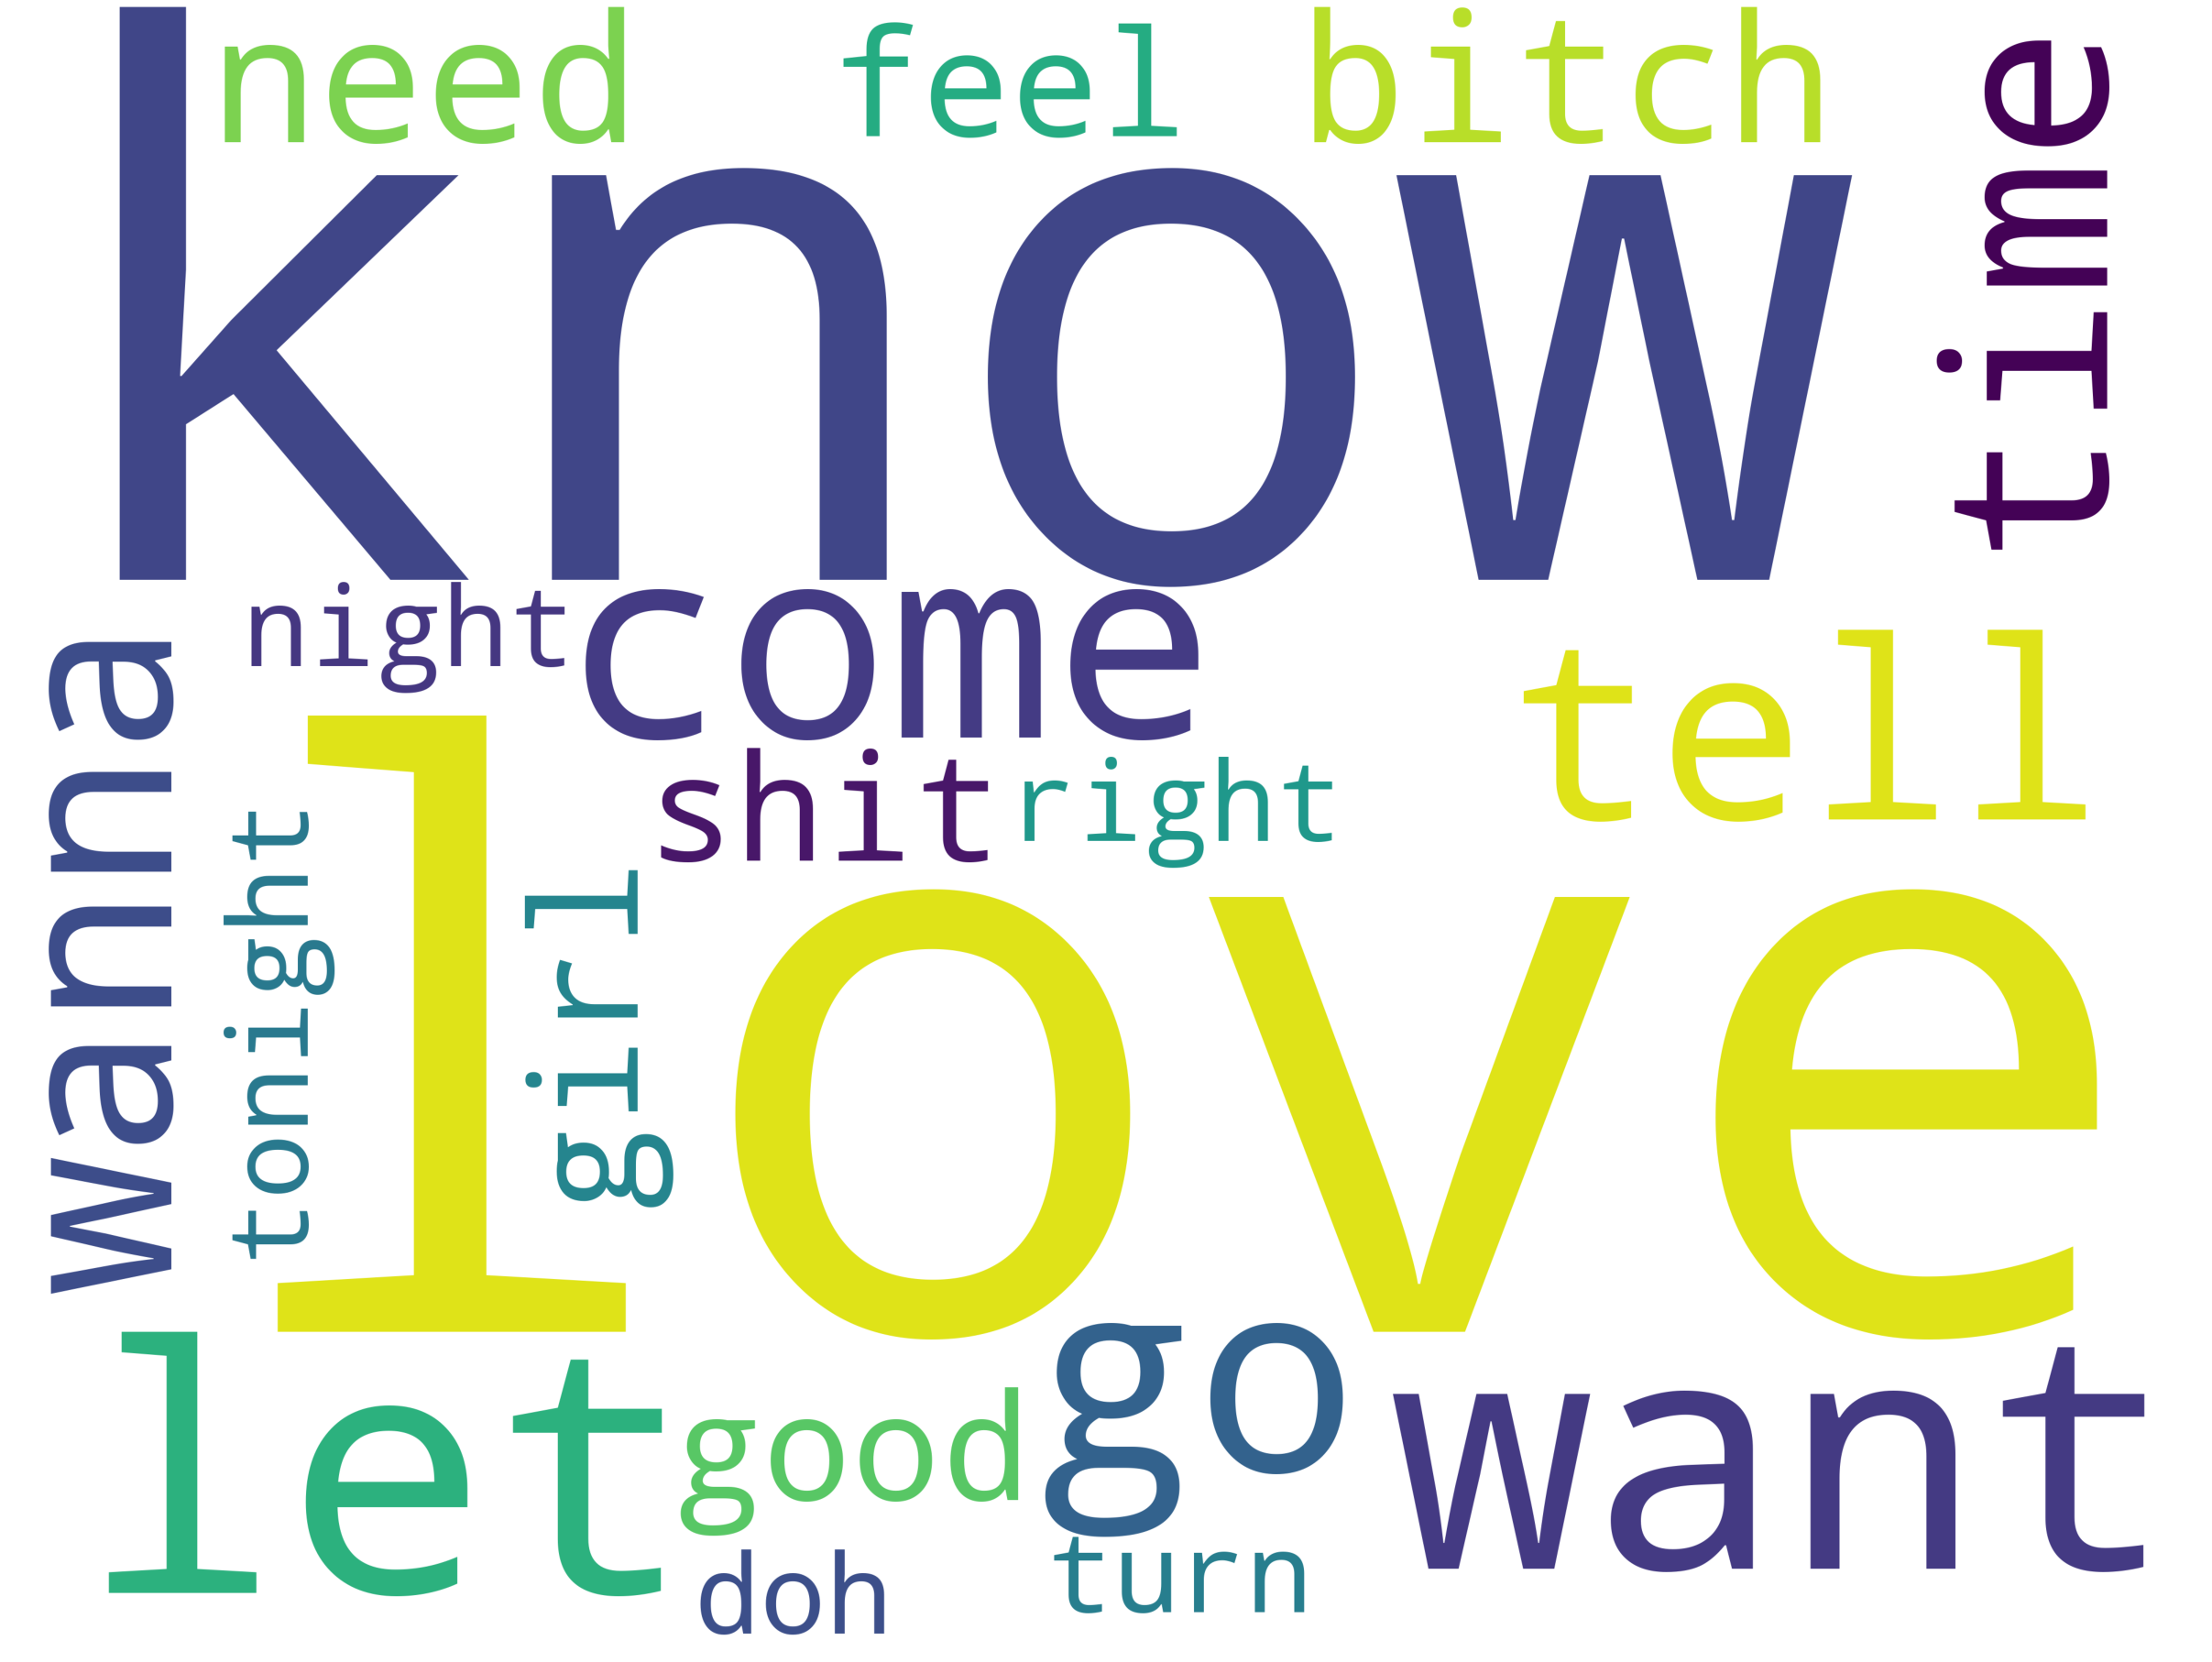

In [68]:
# Create a word cloud of most common terms
years = billboard_df['Year'].unique().tolist()
word_frequencies = pd.DataFrame()
for i in range (0, len(years)):
    year_corpus = str(billboard_df['Lyrics'][billboard_df['Year'] == years[i]].tolist())
    tokens = year_corpus.split(" ")
    counts = Counter(tokens)
    word_frequencies = word_frequencies.append({
        "Year": years[i],
        "Most Common Words": counts.most_common(n=100)
    }, ignore_index=True)
word_frequencies['Year'] = word_frequencies['Year'].astype(int)

characteristics = billboard_df.groupby('Year').count()

top_words = []
for i in range (0, len(word_frequencies)):
    for j in range (0, 10):
        top_words.append(word_frequencies.iloc[i]['Most Common Words'][j][0])
top_words = " ".join(top_words)
top_words = re.sub("what", "", top_words)

wordcloud(top_words, max_words=20)

In [79]:
# Perform sentiment analysis
billboard_df['Compound'] = [sid.polarity_scores(x)['compound'] for x in billboard_df['Lyrics']]
billboard_df['Negative'] = [sid.polarity_scores(x)['neg'] for x in billboard_df['Lyrics']]
billboard_df['Neutral'] = [sid.polarity_scores(x)['neu'] for x in billboard_df['Lyrics']]
billboard_df['Positive'] = [sid.polarity_scores(x)['pos'] for x in billboard_df['Lyrics']]

billboard_df.head()

,Lyrics,Song Title,Year,Word Counts,Unique Word Counts,Compound,Negative,Neutral,Positive
0,wake morning feelin P Diddy girl grab glass do...,TiK ToK,2010,255,99,-0.6942,0.202,0.650,0.148
1,sorry miss leave message beep think tonight kn...,Need You Now,2010,77,48,-0.9025,0.271,0.656,0.074
2,lipstick stain lobe left brain know forget go ...,"Hey, Soul Sister",2010,168,70,0.9423,0.114,0.652,0.234
3,greeting love one let journey know place grass...,California Gurls,2010,316,125,0.9967,0.034,0.667,0.299
4,gosh let gon let beat rock let love way love b...,OMG,2010,498,60,0.9986,0.033,0.454,0.513


In [156]:
# Aggregate sentiment scores for visualization
billboard_sentiment = billboard_df.groupby(["Year"]).mean()
billboard_sentiment.head(10)

,Word Counts,Unique Word Counts,Compound,Negative,Neutral,Positive
Year,,,,,,
2010,225.657407,90.416667,0.346953,0.158296,0.595537,0.246194
2011,230.908163,92.459184,0.405898,0.163500,0.595357,0.241163
2012,194.910000,80.600000,0.408464,0.150950,0.595790,0.253290
2013,312.734694,128.112245,0.332018,0.159745,0.567429,0.272898
2014,210.949495,79.363636,0.365109,0.139848,0.632869,0.227263
2015,207.000000,87.101010,0.218422,0.181949,0.579768,0.238232
2016,231.929293,99.898990,0.171286,0.176253,0.593949,0.229747
2017,247.565657,102.606061,0.071339,0.180657,0.607798,0.211545
2018,282.555556,117.848485,-0.006009,0.175101,0.622717,0.202212


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


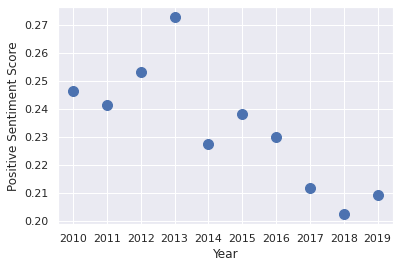

In [190]:
# Create a scatter plot of aggregated positive sentiment scores per Billboard
# year
data = np.random.randn(20, 5);

# Prepare data
data={'Year':['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
              '2018', '2019'],
      'Positive Sentiment Score':billboard_sentiment['Positive'].to_numpy()}
  
# Load data into DataFrame
df = pd.DataFrame(data = data);
  
# Draw a scatter plot
df.plot.scatter(x = 'Year', y = 'Positive Sentiment Score', s = 100);